IMPORTING

In [109]:
# Core libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore, f_oneway

# Data preprocessing and manipulation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# Model evaluation and splitting
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Statistical models and tests
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



LOAD DATASET

In [110]:
# Load the dataset
data =('1995-2024_fuel_consumption.csv')
df = pd.read_csv(data,encoding='latin-1')
print(df.head())

   Model year   Make         Model Vehicle class  Engine size (L)  Cylinders  \
0        1995  Acura       Integra    Subcompact              1.8          4   
1        1995  Acura       Integra    Subcompact              1.8          4   
2        1995  Acura  Integra GS-R    Subcompact              1.8          4   
3        1995  Acura        Legend       Compact              3.2          6   
4        1995  Acura  Legend Coupe       Compact              3.2          6   

  Transmission Fuel type  City (L/100 km)  Highway (L/100 km)  \
0           A4         X             10.2                 7.0   
1           M5         X              9.6                 7.0   
2           M5         Z              9.4                 7.0   
3           A4         Z             12.6                 8.9   
4           A4         Z             13.0                 9.3   

   Combined (L/100 km)  Combined (mpg)  CO2 emissions (g/km)  Unnamed: 13  
0                  8.8              32              

DATA DESCRIPTION

In [111]:
# Data description and info
print(df.info())
print(df.describe())

# See all columns
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27722 entries, 0 to 27721
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            27722 non-null  int64  
 1   Make                  27722 non-null  object 
 2   Model                 27722 non-null  object 
 3   Vehicle class         27722 non-null  object 
 4   Engine size (L)       27722 non-null  float64
 5   Cylinders             27722 non-null  int64  
 6   Transmission          27722 non-null  object 
 7   Fuel type             27722 non-null  object 
 8   City (L/100 km)       27722 non-null  float64
 9   Highway (L/100 km)    27722 non-null  float64
 10  Combined (L/100 km)   27722 non-null  float64
 11  Combined (mpg)        27722 non-null  int64  
 12  CO2 emissions (g/km)  27722 non-null  int64  
 13  Unnamed: 13           4525 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 3.0+ MB
None
        

IDENTIFYING NUMERICAL CATEGORICAL FEATURES

In [112]:
# Identifying numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print("numerical_features:", numerical_features)
print("categorical_features:", categorical_features)


numerical_features: Index(['Model year', 'Engine size (L)', 'Cylinders', 'City (L/100 km)',
       'Highway (L/100 km)', 'Combined (L/100 km)', 'Combined (mpg)',
       'CO2 emissions (g/km)', 'Unnamed: 13'],
      dtype='object')
categorical_features: Index(['Make', 'Model', 'Vehicle class', 'Transmission', 'Fuel type'], dtype='object')


CORRELATION MATRIX

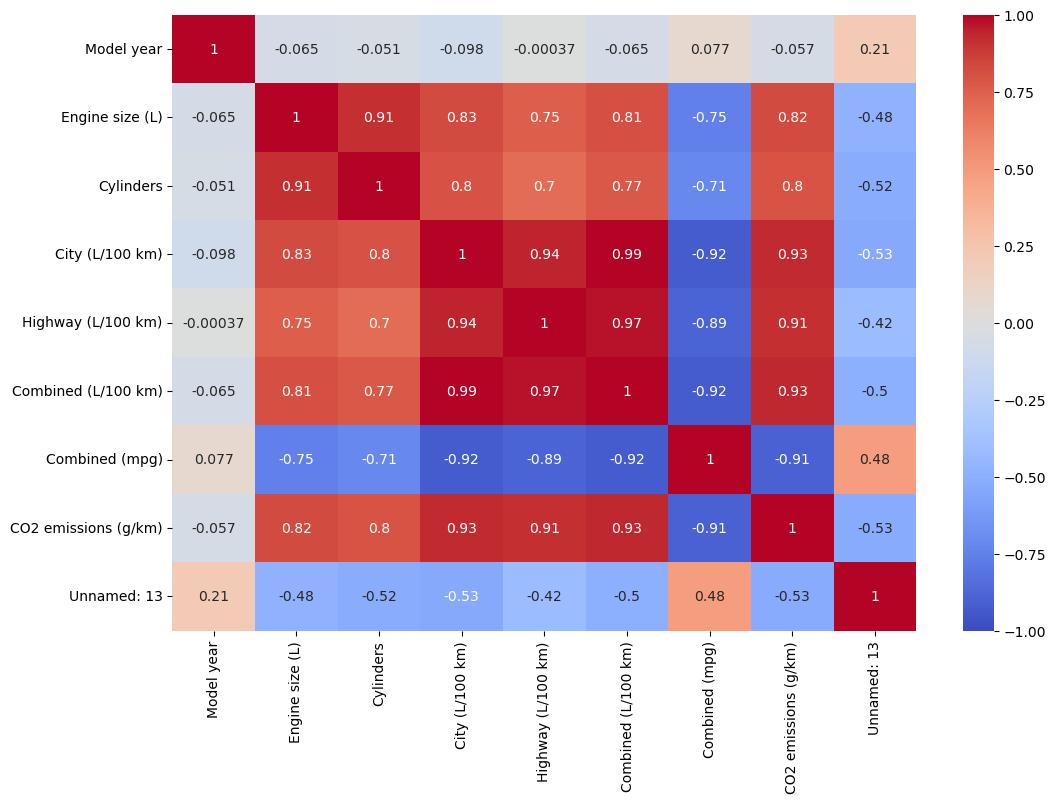

In [113]:
# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [114]:
# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Set correlation threshold
threshold = 0.7

# Select upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find columns with positive correlation greater than or equal to the threshold
high_corr_pairs = upper_triangle.stack().loc[lambda x: x >= threshold]  # Only positive correlations

# Get unique feature names involved in high correlation pairs
high_corr_features = set(high_corr_pairs.index.get_level_values(0)).union(set(high_corr_pairs.index.get_level_values(1)))

# Output the selected numerical features
numericalfeatures=(list(high_corr_features))
print(numericalfeatures)

['City (L/100 km)', 'Engine size (L)', 'Combined (L/100 km)', 'Cylinders', 'Highway (L/100 km)', 'CO2 emissions (g/km)']


ANOVA ONE-WAY

In [115]:
# List of categorical features
categorical_features = ['Make', 'Model', 'Vehicle class', 'Transmission', 'Fuel type']

# Perform ANOVA for each categorical feature against the target (CO2 emissions)
for cat_feature in categorical_features:
    # Get unique categories for the categorical feature
    categories = df[cat_feature].unique()

    # Create a list of CO2 emissions for each category
    category_groups = [df[df[cat_feature] == category]['CO2 emissions (g/km)'].values for category in categories]

    # Perform ANOVA using f_oneway
    f_stat, p_value = f_oneway(*category_groups)

    print(f"ANOVA results for {cat_feature}: F-statistic = {f_stat}, p-value = {p_value}")


ANOVA results for Make: F-statistic = 336.74356082016095, p-value = 0.0
ANOVA results for Model: F-statistic = 65.0414516479652, p-value = 0.0
ANOVA results for Vehicle class: F-statistic = 883.2341428702805, p-value = 0.0
ANOVA results for Transmission: F-statistic = 204.12547550644598, p-value = 0.0
ANOVA results for Fuel type: F-statistic = 209.72905669177078, p-value = 1.3961379342101418e-177


Z-SCORE AND OUTLIERS

In [116]:
# Calculate Q1 and Q3 for numerical features only
Q1 = df.select_dtypes(include=['int64', 'float64']).quantile(0.25)
Q3 = df.select_dtypes(include=['int64', 'float64']).quantile(0.75)
IQR = Q3 - Q1

# Detecting outliers using IQR
numerical_df = df.select_dtypes(include=['int64', 'float64'])
outliers_iqr = ((numerical_df < (Q1 - 1.5 * IQR)) | (numerical_df > (Q3 + 1.5 * IQR)))

# Calculate z-scores for numerical features
numerical_df = df.select_dtypes(include=['int64', 'float64'])
z = np.abs(stats.zscore(numerical_df))

# Detecting outliers using z-score with threshold of 3
outliers_zscore = (z > 3)

# Print outliers detected by both methods
print("Outliers detected by IQR:\n", outliers_iqr)
print("\nOutliers detected by z-score:\n", outliers_zscore)

Outliers detected by IQR:
        Model year  Engine size (L)  Cylinders  City (L/100 km)  \
0           False            False      False            False   
1           False            False      False            False   
2           False            False      False            False   
3           False            False      False            False   
4           False            False      False            False   
...           ...              ...        ...              ...   
27717       False            False      False            False   
27718       False            False      False            False   
27719       False            False      False            False   
27720       False            False      False            False   
27721       False            False      False            False   

       Highway (L/100 km)  Combined (L/100 km)  Combined (mpg)  \
0                   False                False           False   
1                   False                False  

DEFINE FEATURES

In [117]:
# Define categorical and numerical features
categoricalfeatures = ['Make', 'Vehicle class', 'Transmission', 'Fuel type']
numericalfeatures = ['Cylinders', 'Engine size (L)', 'Highway (L/100 km)', 'Combined (L/100 km)', 'City (L/100 km)']

BOX PLOT

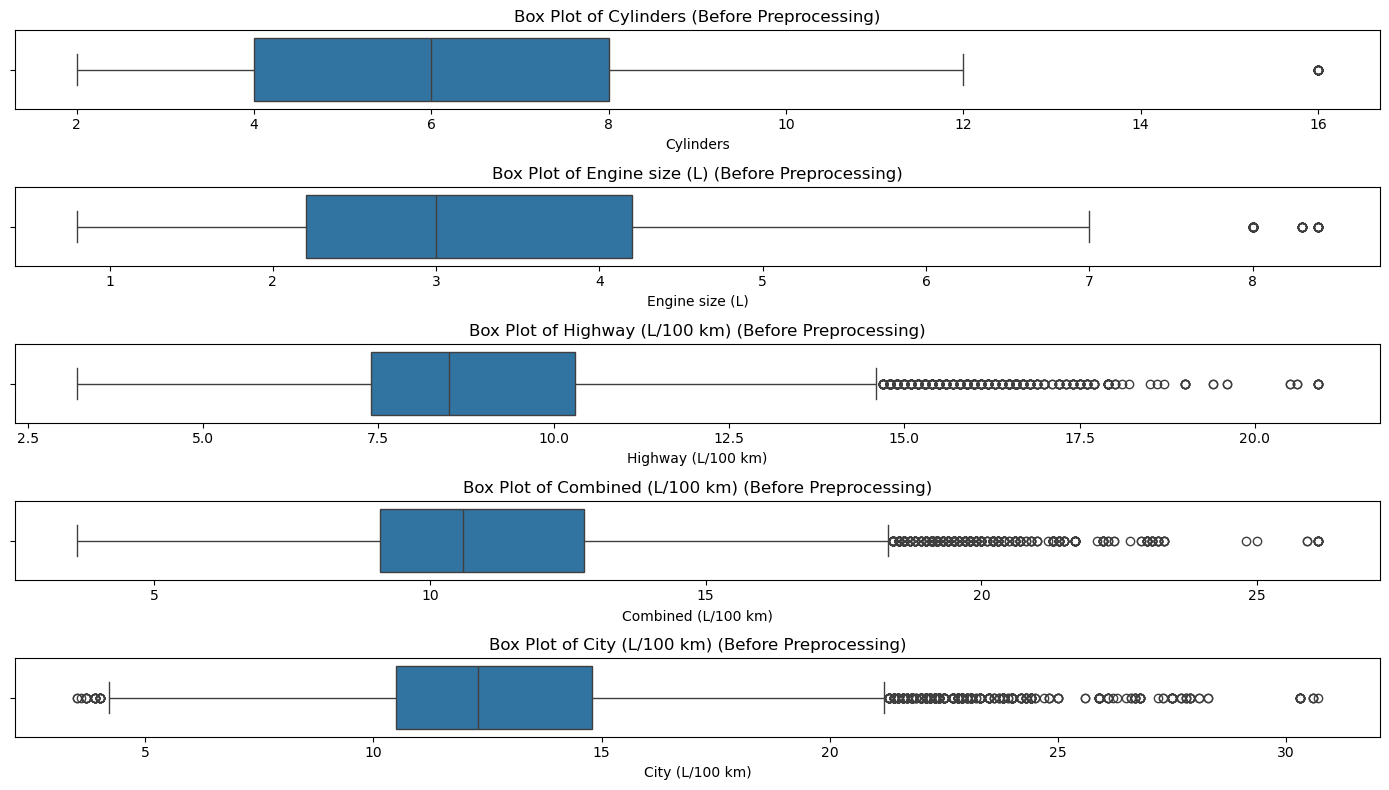

In [118]:
# Function to plot individual box plots for each numerical feature before preprocessing
def plot_boxplot_before(df, numericalfeatures):
    plt.figure(figsize=(14, 8))
    for i, feature in enumerate(numericalfeatures):
        plt.subplot(len(numericalfeatures), 1, i + 1)  # Create subplots for each feature
        sns.boxplot(x=df[feature], orient='h')
        plt.title(f"Box Plot of {feature} (Before Preprocessing)")
        plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

# Call the function to plot the boxplot for original data
plot_boxplot_before(df, numericalfeatures)


PIPELINE AND PREPROCESSING

In [119]:
# Define custom transformer for outlier handling
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        z_scores = np.abs(zscore(X))
        return X[(z_scores < self.threshold).all(axis=1)]

# Define function to ensure no negative values before log transformation
class NonNegativeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_value=0.1):
        self.min_value = min_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.maximum(X, self.min_value)

# Define categorical and numerical features
categoricalfeatures = ['Make', 'Vehicle class', 'Transmission', 'Fuel type']
numericalfeatures = ['Cylinders', 'Engine size (L)', 'Highway (L/100 km)', 'Combined (L/100 km)', 'City (L/100 km)']

# Convert numerical features to numeric type
for col in numericalfeatures:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Define preprocessing pipelines
numerical_pipeline = Pipeline([
    ('non_negative', NonNegativeTransformer(min_value=0.1)),
    ('minmax_scaler', MinMaxScaler(feature_range=(0, 6))),
    ('log_transform', FunctionTransformer(np.log1p, validate=True))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numericalfeatures),
    ('cat', categorical_pipeline, categoricalfeatures)
])


EDA

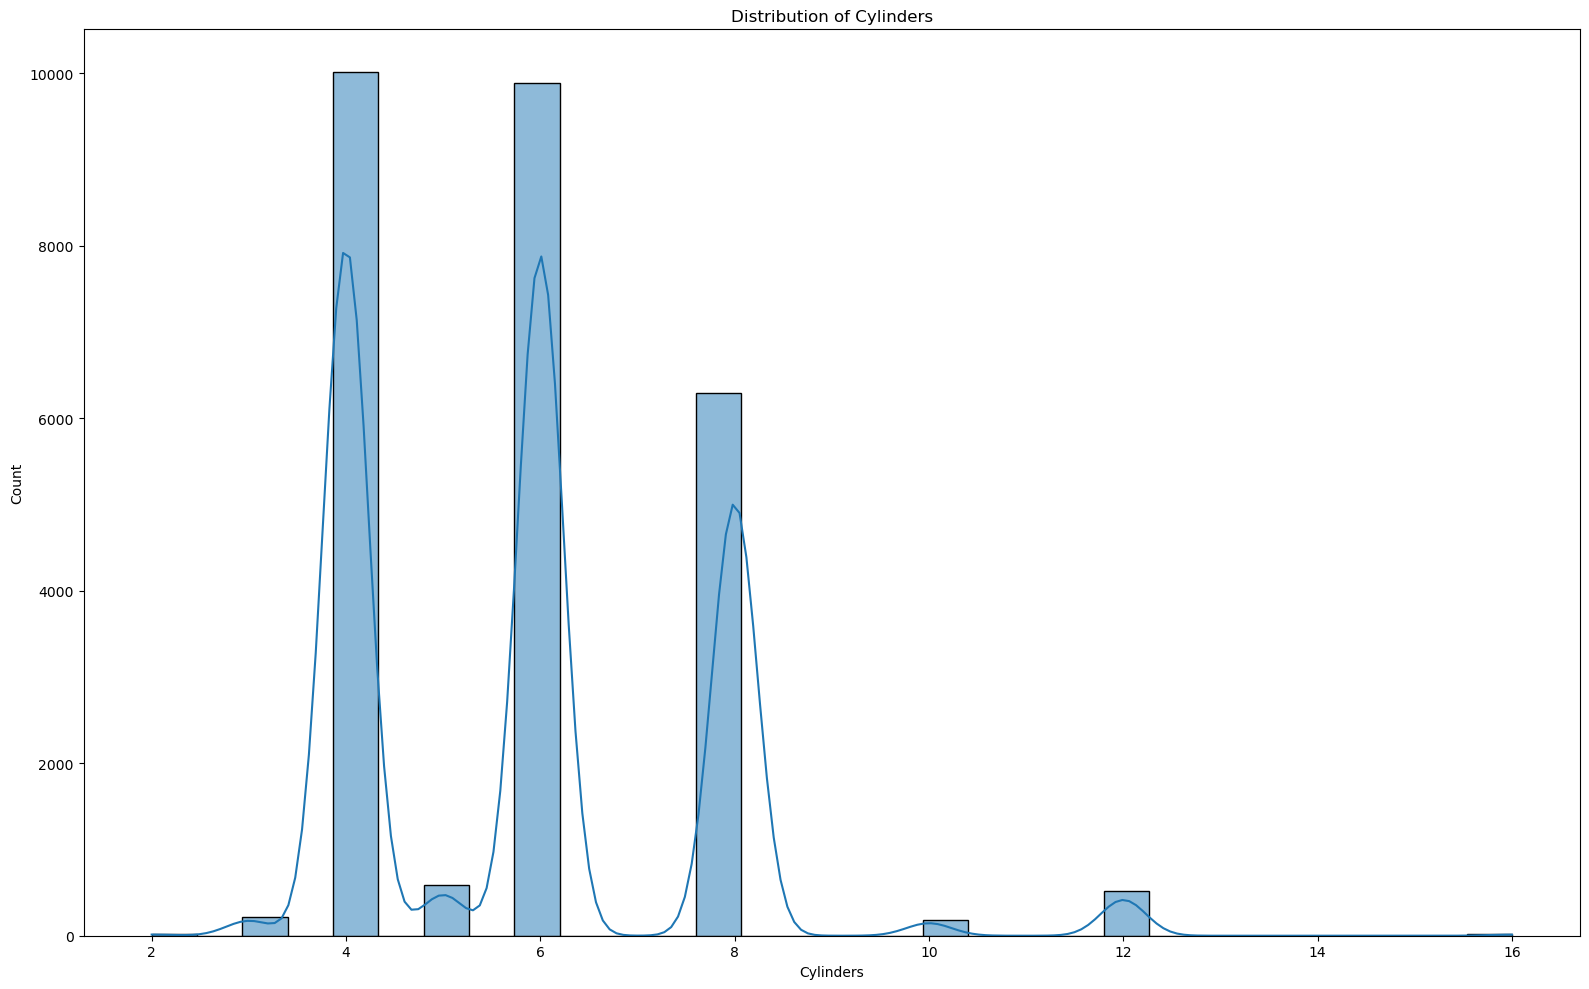

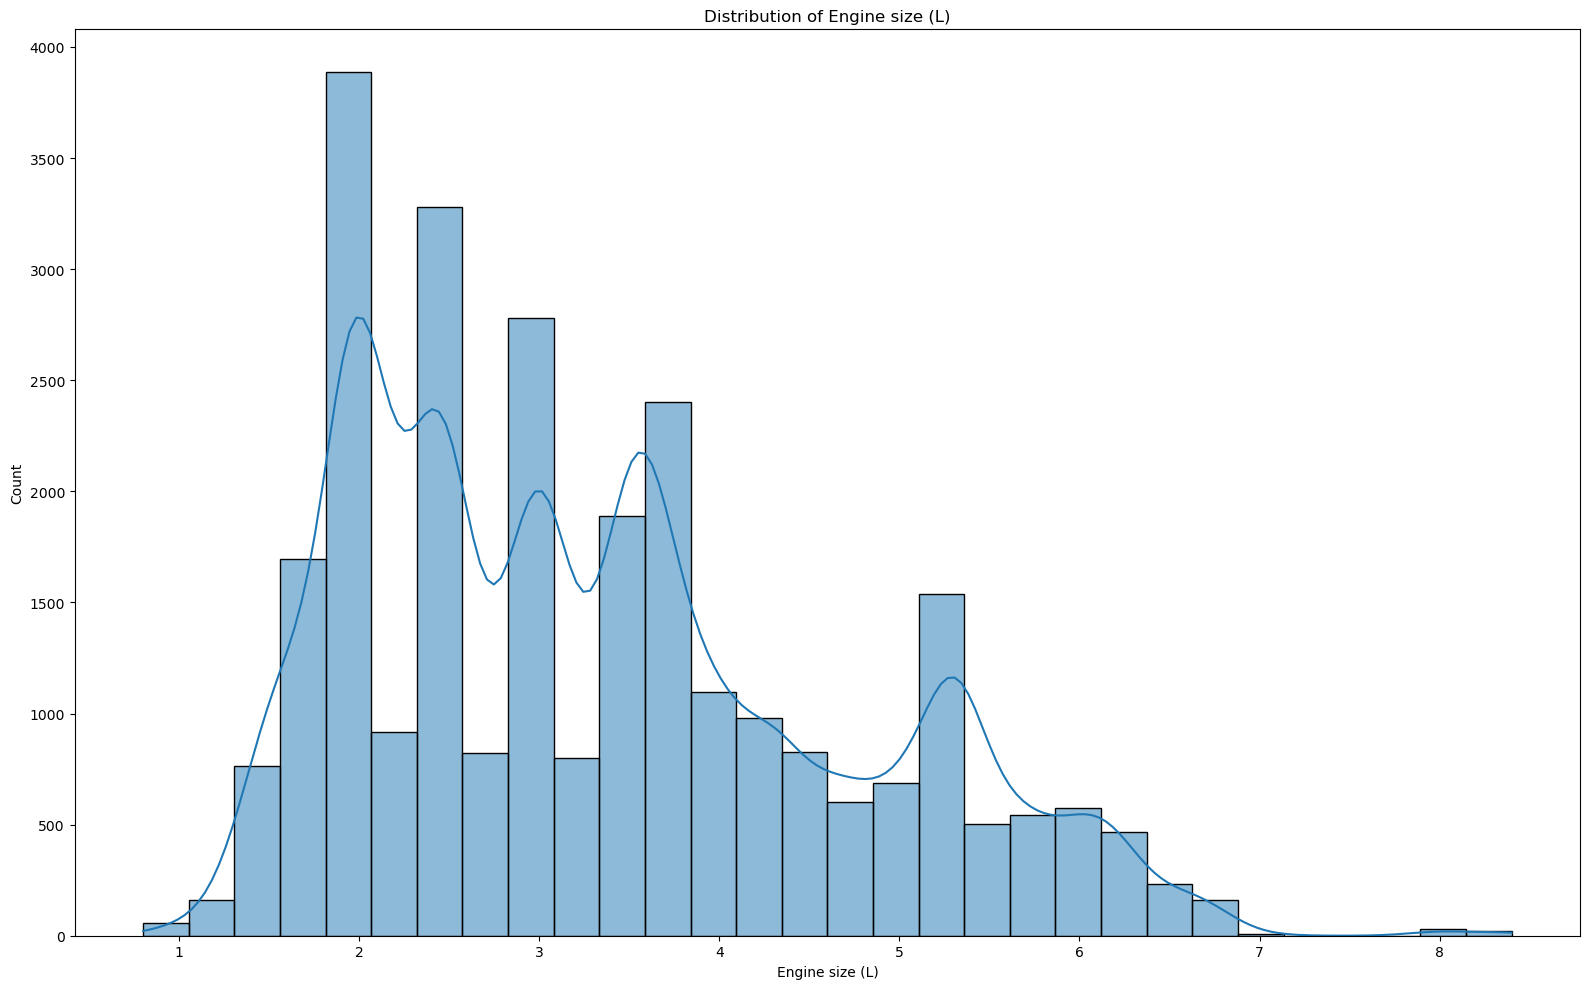

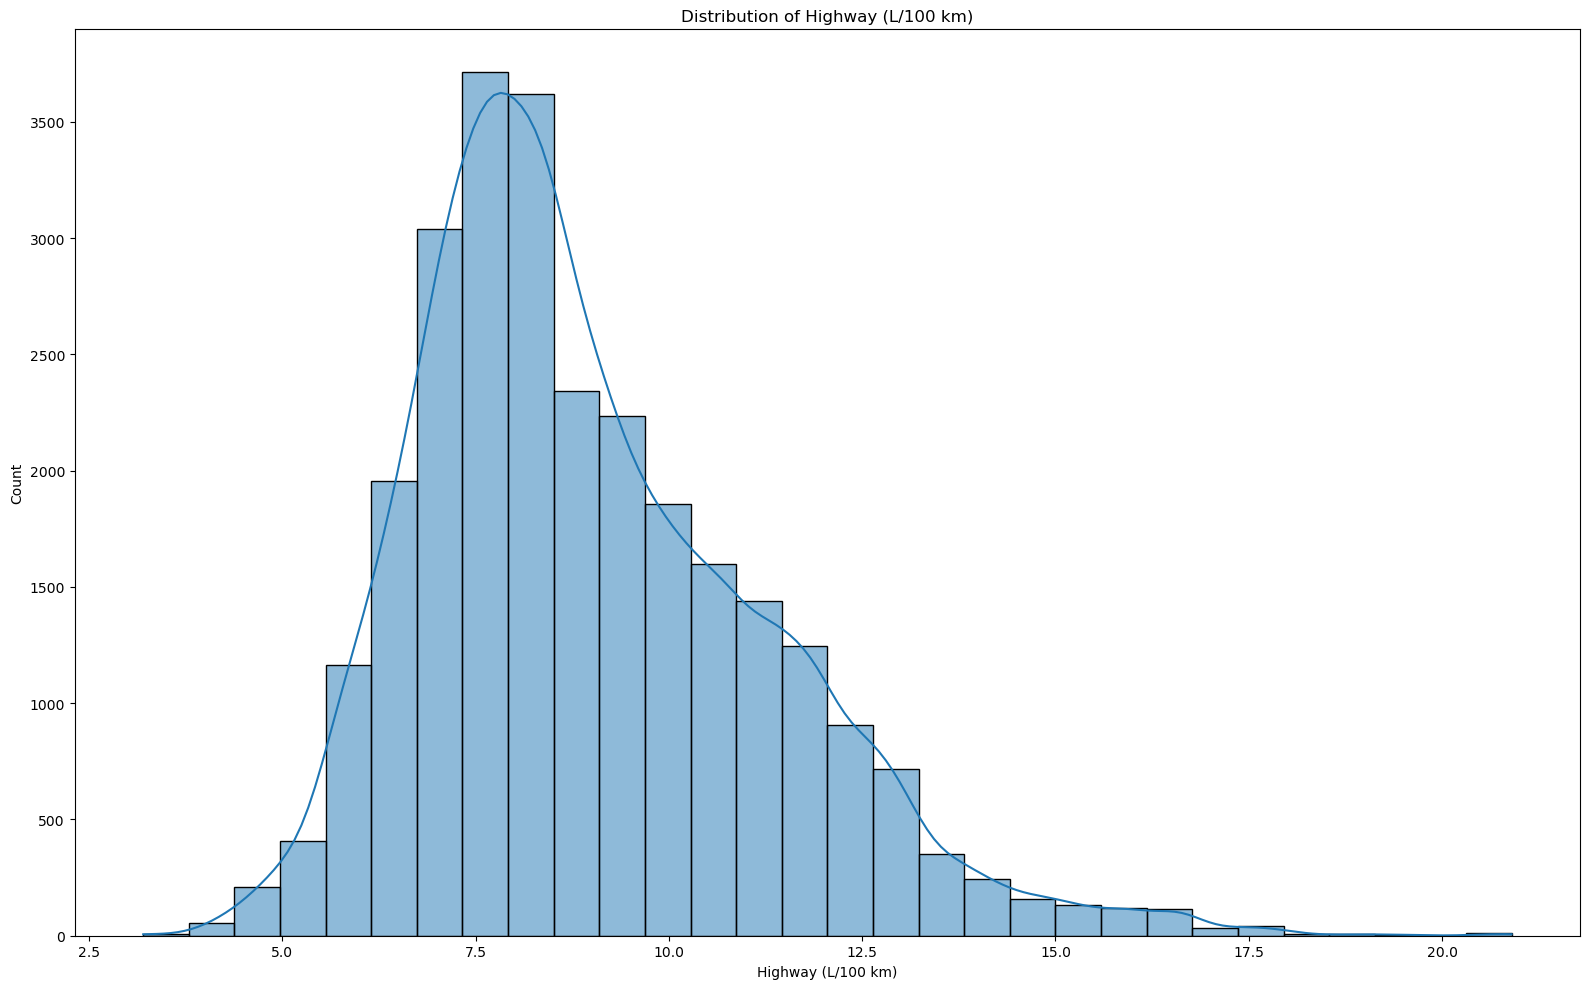

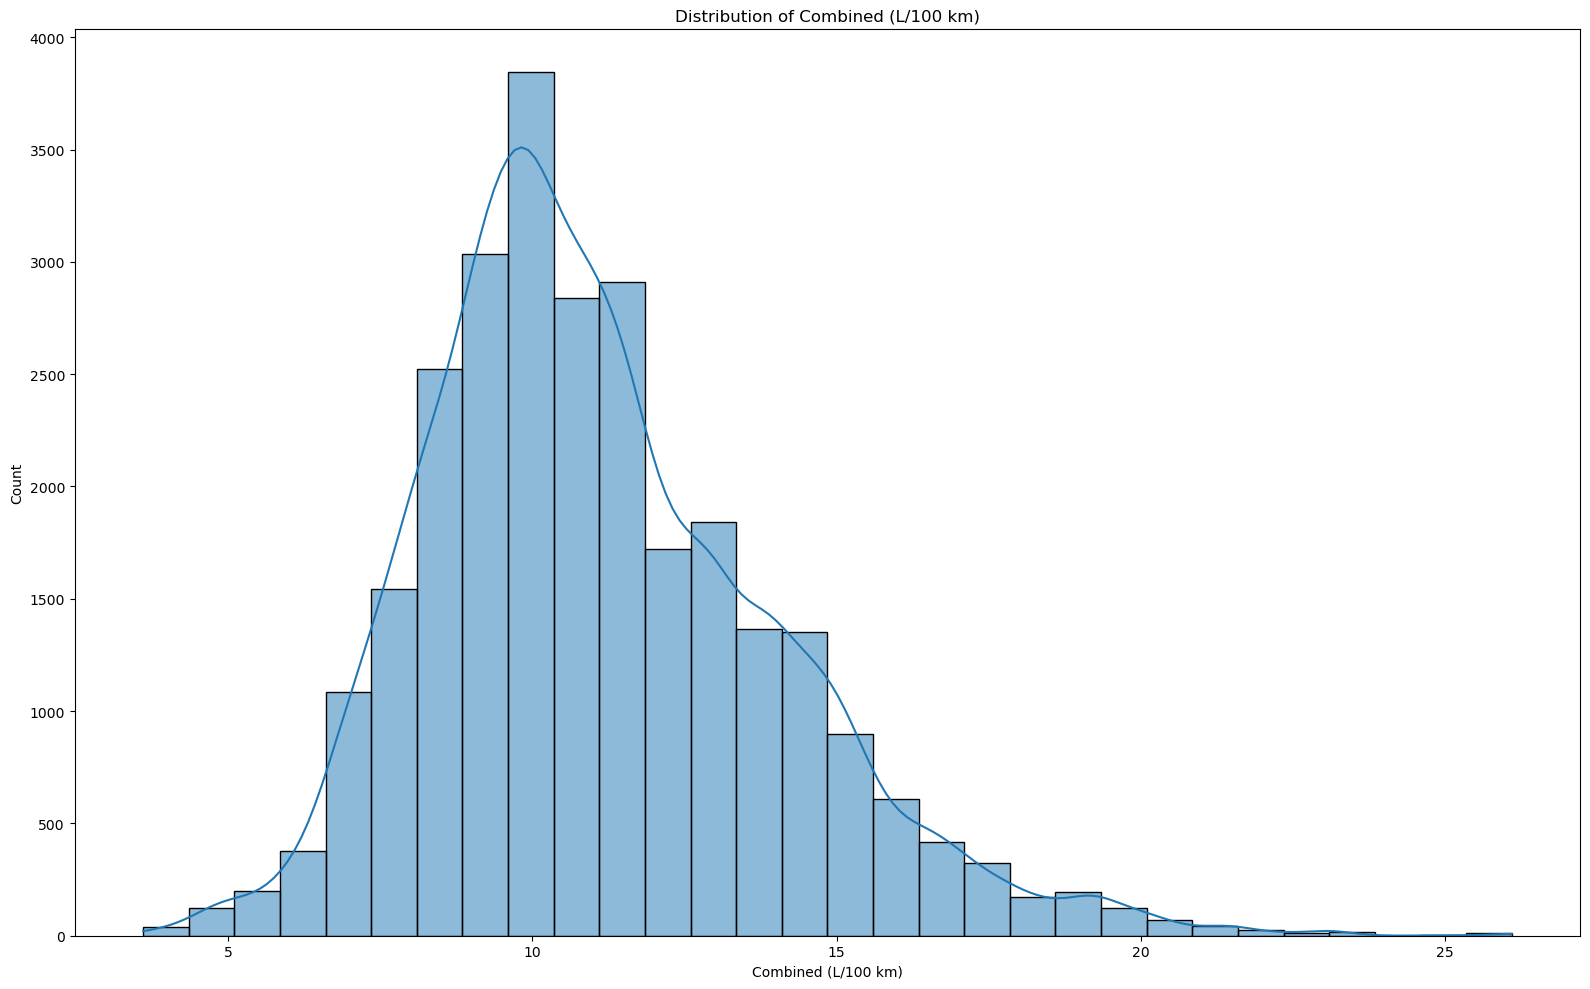

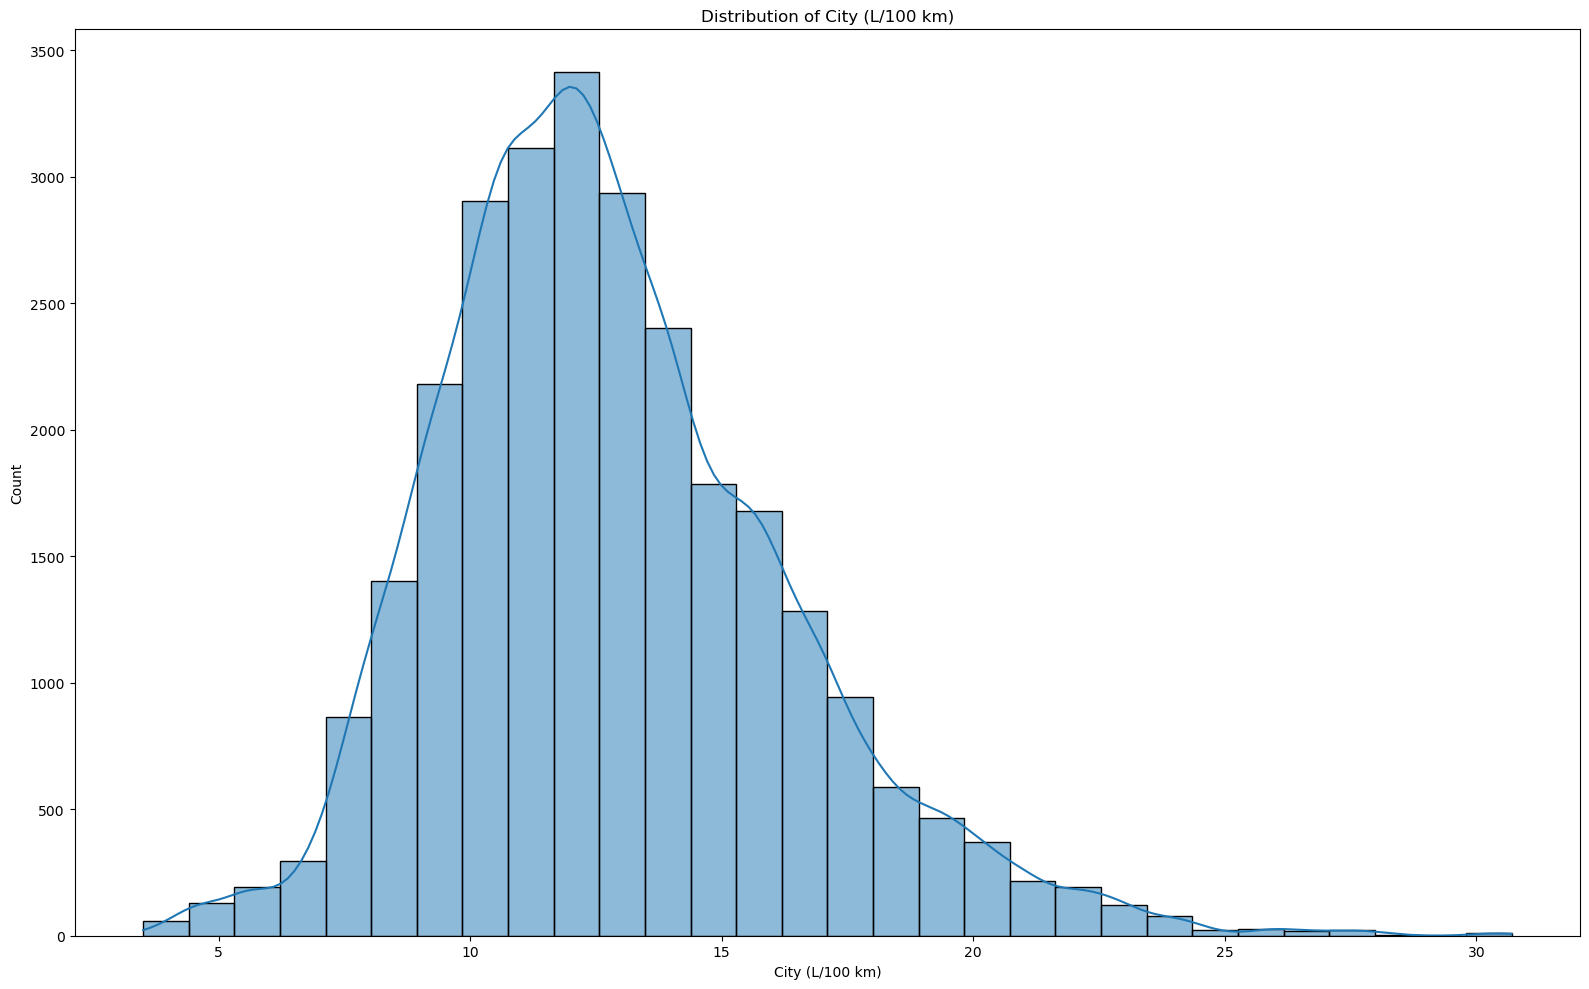

In [120]:
for col in numericalfeatures:
    plt.figure(figsize=(16,10))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

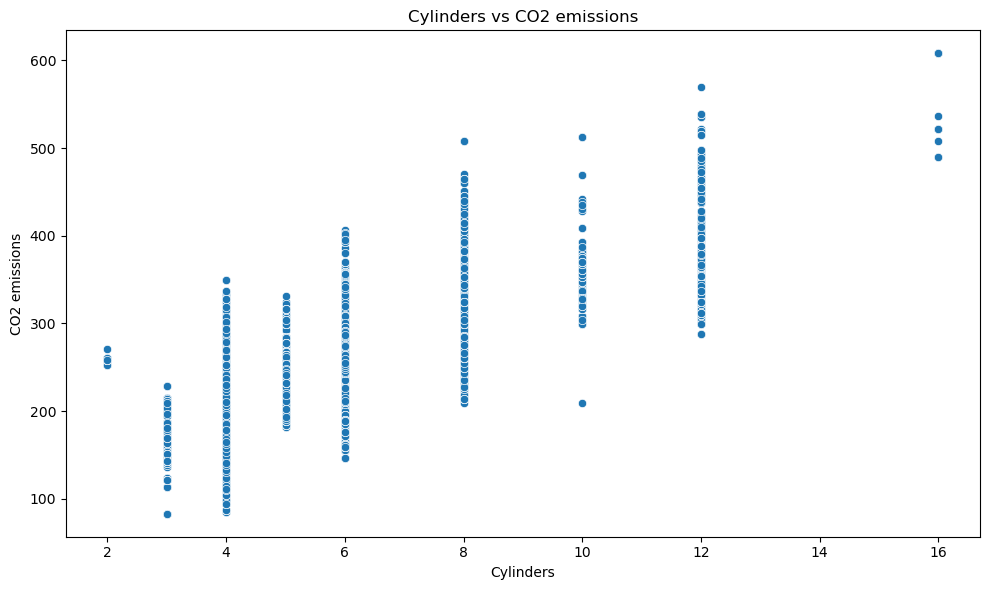

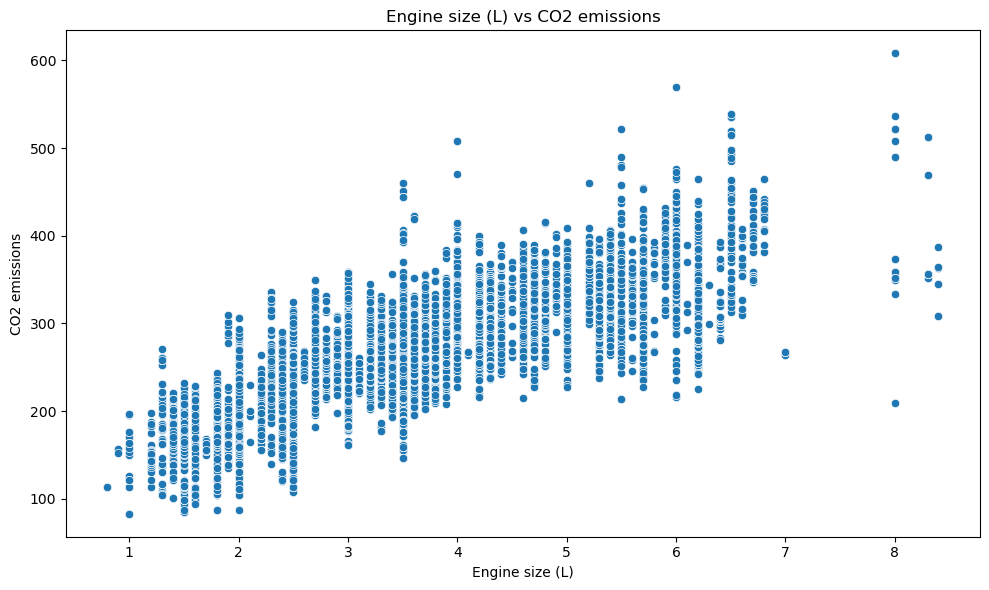

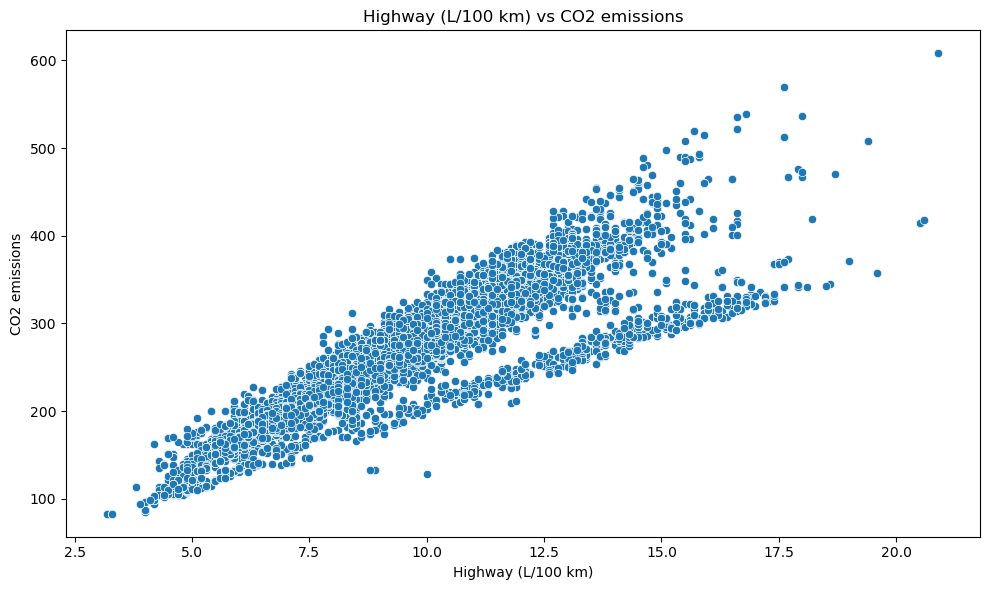

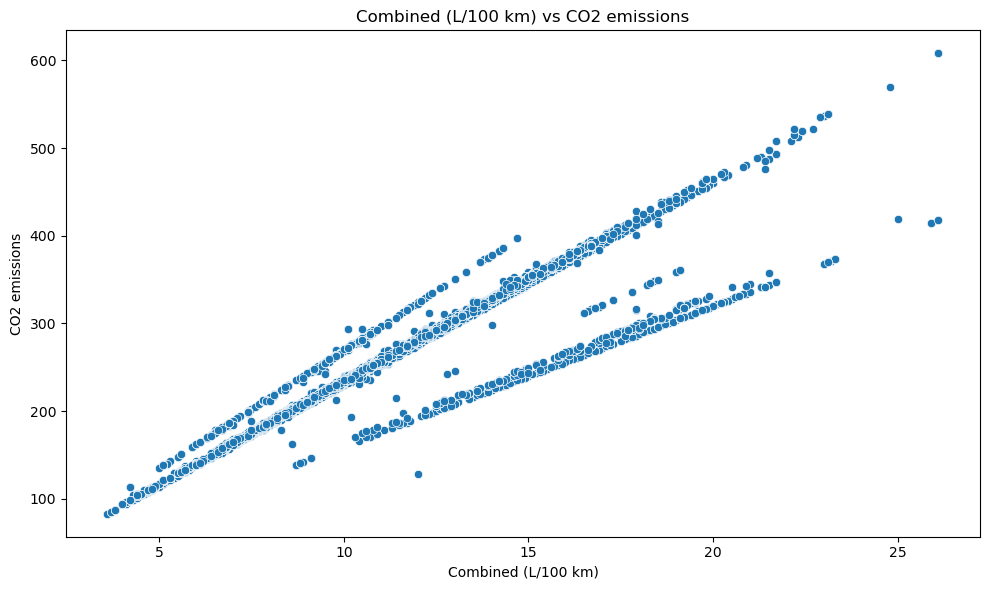

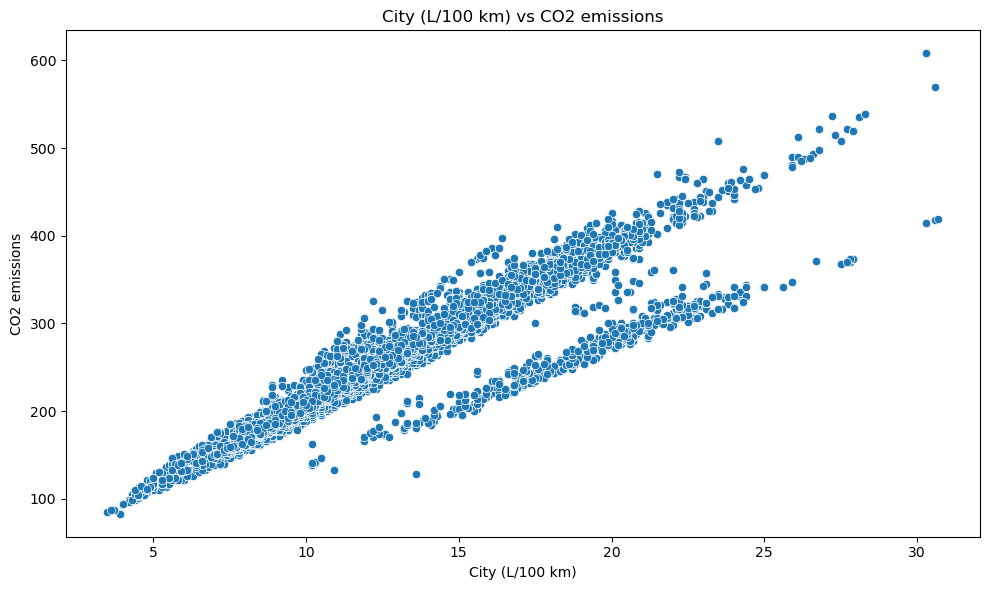

In [121]:
for col in numericalfeatures:
    if col != 'CO2 emissions (g/km)':
        plt.figure(figsize=(10,6))
        sns.scatterplot(x=df[col], y=df['CO2 emissions (g/km)'])
        plt.title(f'{col} vs CO2 emissions')
        plt.xlabel(col)
        plt.ylabel('CO2 emissions')
        plt.tight_layout()
        plt.show()

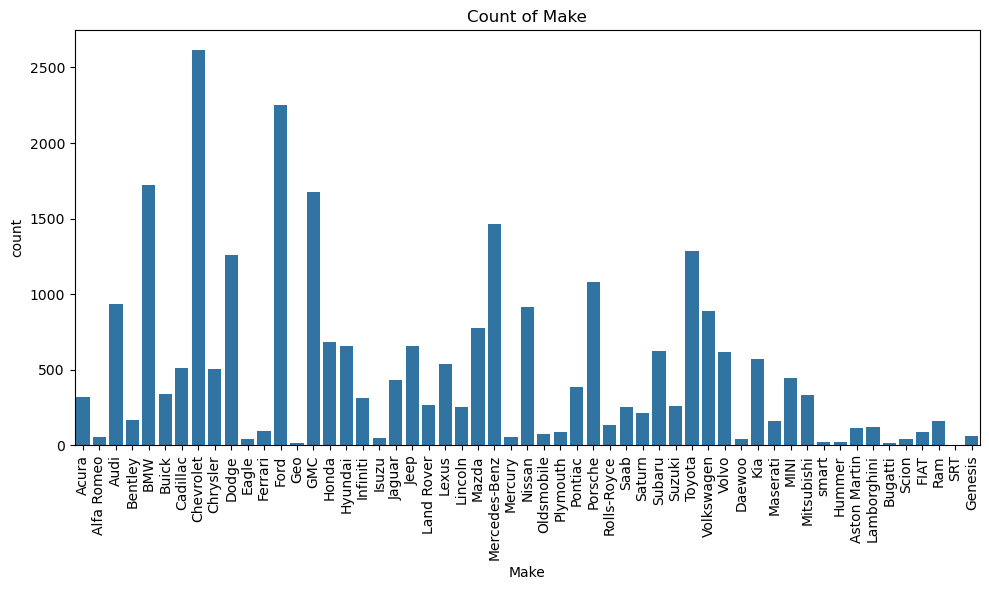

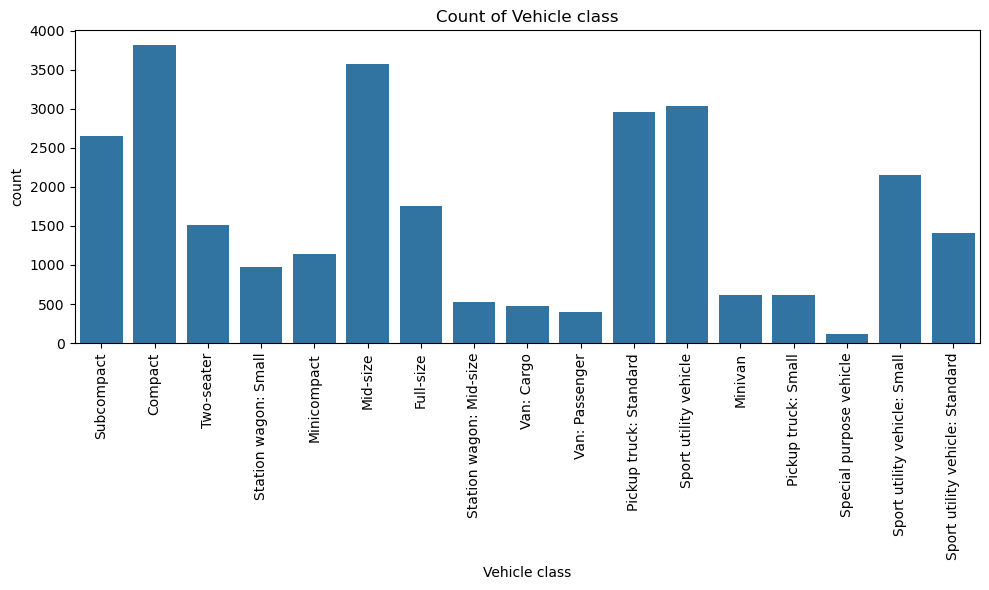

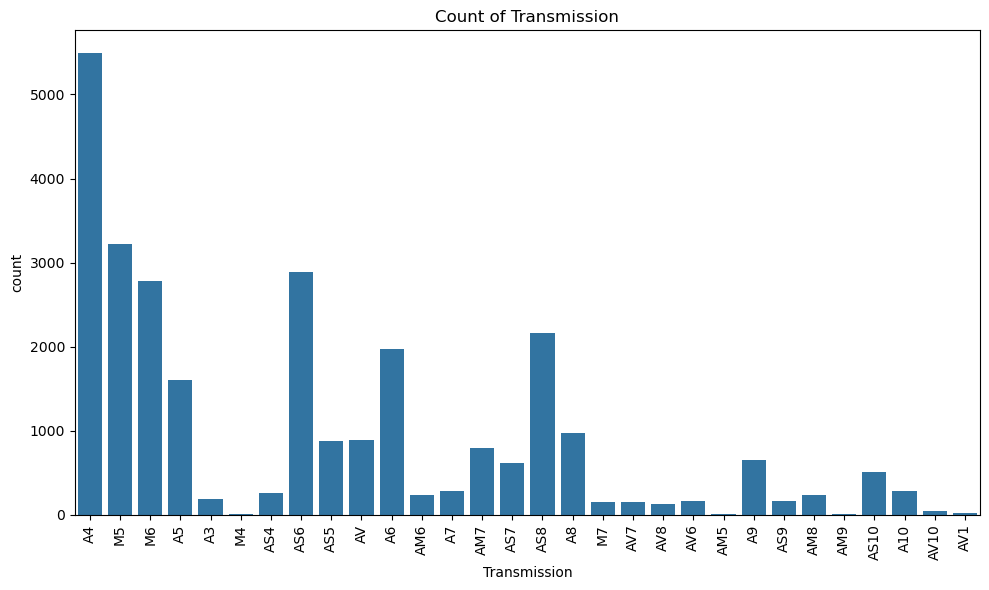

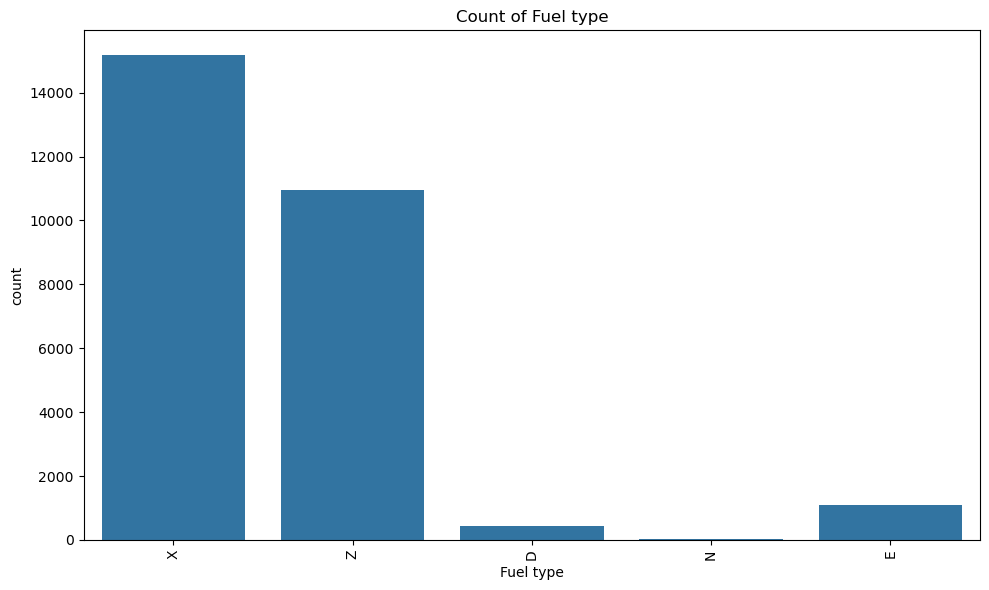

In [122]:
# Plot count of categorical features using simple bar charts
for col in categoricalfeatures:
    plt.figure(figsize=(10,6))
    # Create a count plot without palette
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()


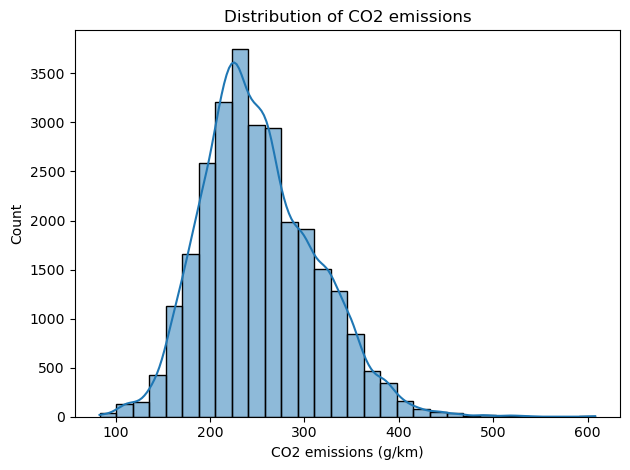

In [123]:
sns.histplot(df['CO2 emissions (g/km)'], bins=30, kde=True)
plt.title('Distribution of CO2 emissions')
plt.tight_layout()
plt.show()


SPLITTING DATA AND PROCESSING AFTER SPLITTING OF DATA

In [124]:
# Split the data into train, validation, and test sets
X = df[numericalfeatures + categoricalfeatures]
y = df['CO2 emissions (g/km)']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Outlier removal
outlier_remover = OutlierRemover(threshold=3)
X_train_num = X_train[numericalfeatures]
X_train_num = outlier_remover.fit_transform(X_train_num)
X_train = X_train.loc[X_train_num.index]
y_train = y_train[X_train_num.index]

# Apply preprocessing using the ColumnTransformer
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Debug: Check shape of transformed data and column names
print("Shape of X_train_transformed:", X_train_transformed.shape)

num_transformed_columns = (
    [f"{col}_scaled" for col in numericalfeatures] +
    list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categoricalfeatures))
)

print("Number of transformed columns:", len(num_transformed_columns))
print("Sample column names:", num_transformed_columns[:10])  # Print first 10 column names for checking

# Convert the transformed data to DataFrame
# Check if X_train_transformed is a sparse matrix
if hasattr(X_train_transformed, 'toarray'):
    X_train_transformed = X_train_transformed.toarray()

# Check the shape again after conversion
print("Shape of X_train_transformed (after toarray):", X_train_transformed.shape)

# Ensure the number of columns matches
if X_train_transformed.shape[1] == len(num_transformed_columns):
    X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=num_transformed_columns)
else:
    raise ValueError("Mismatch between number of columns in transformed data and column names.")


Shape of X_train_transformed: (21477, 110)
Number of transformed columns: 110
Sample column names: ['Cylinders_scaled', 'Engine size (L)_scaled', 'Highway (L/100 km)_scaled', 'Combined (L/100 km)_scaled', 'City (L/100 km)_scaled', 'Make_Acura', 'Make_Alfa Romeo', 'Make_Aston Martin', 'Make_Audi', 'Make_BMW']
Shape of X_train_transformed (after toarray): (21477, 110)


BOX PLOT AFTER PROCESSING

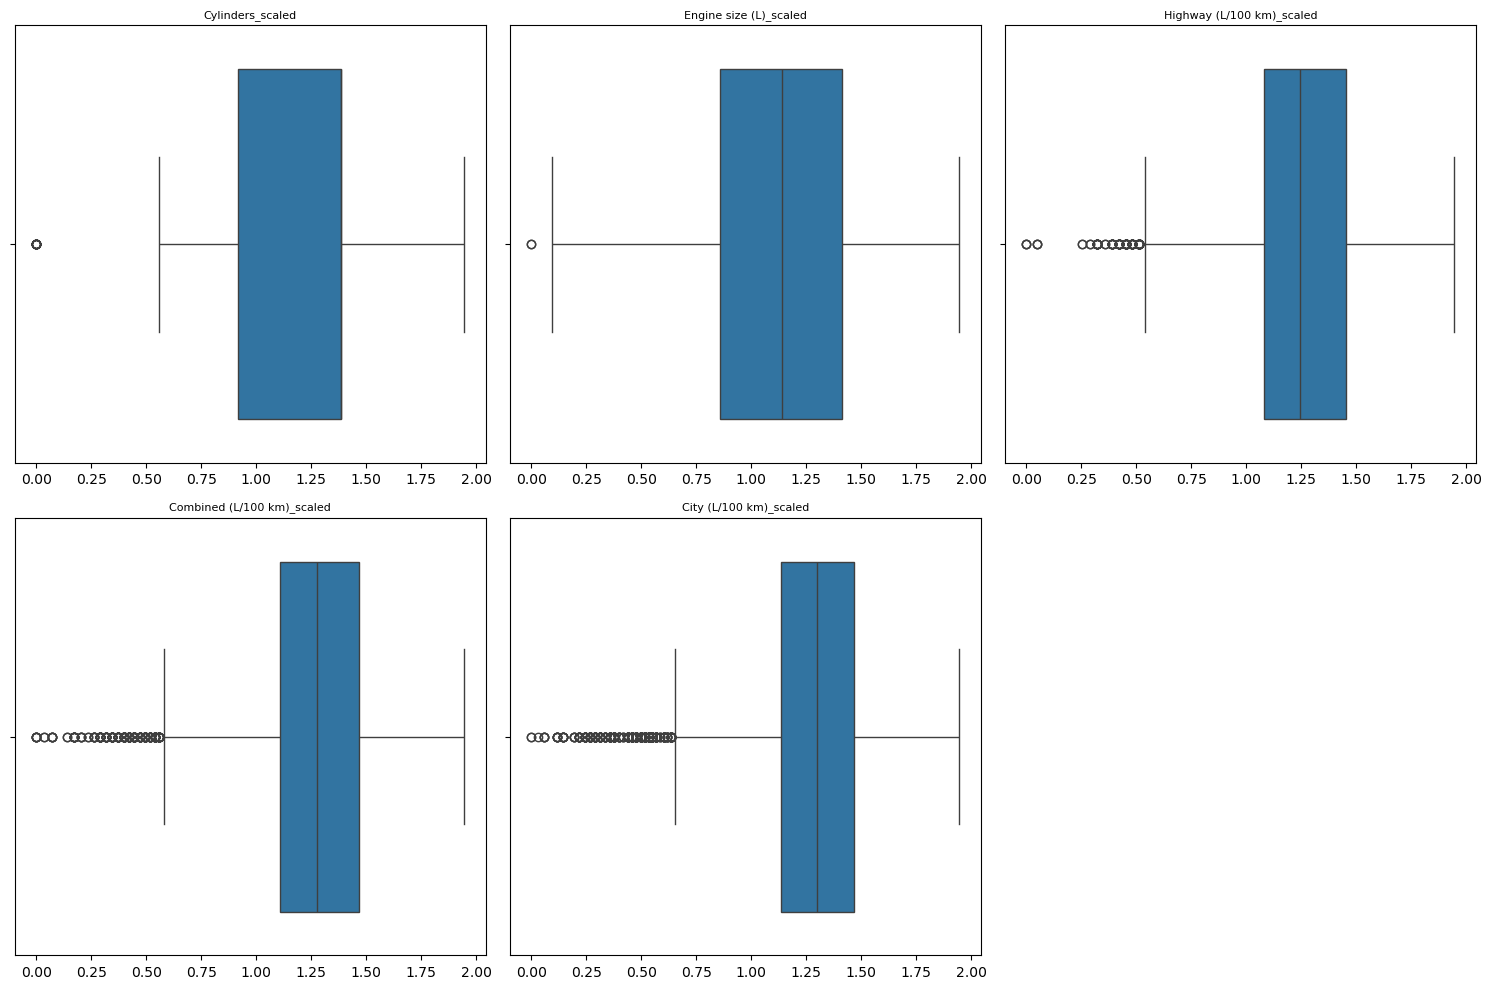

In [125]:
# Plot box plots for transformed numerical features
plt.figure(figsize=(15, 10))  # Adjust figure size based on number of features

# Plot only for transformed numerical features
transformed_numerical_columns = [col for col in num_transformed_columns if '_scaled' in col]


for i, feature in enumerate(transformed_numerical_columns):
    plt.subplot(len(transformed_numerical_columns) // 3 + 1, 3, i + 1)  # More flexible grid layout
    sns.boxplot(x=X_train_transformed_df[feature])
    plt.title(f'{feature}', fontsize=8)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

MODEL EVALUATION THROUGH PIPELINE

In [126]:
# Define model pipelines
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model_pipeline = Pipeline([
        ('model', model)
    ])
    model_pipeline.fit(X_train_transformed, y_train)
    y_val_pred = model_pipeline.predict(X_val_transformed)
    y_test_pred = model_pipeline.predict(X_test_transformed)

    val_metrics = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'R^2': r2_score(y_val, y_val_pred),
        'Explained Variance': explained_variance_score(y_val, y_val_pred)
    }

    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R^2': r2_score(y_test, y_test_pred),
        'Explained Variance': explained_variance_score(y_test, y_test_pred)
    }

    results[name] = {
        'Validation Metrics': val_metrics,
        'Test Metrics': test_metrics
    }

# Print evaluation results
for model_name, metrics in results.items():
    print(f"\n{model_name} - Validation Metrics:")
    for metric_name, metric_value in metrics['Validation Metrics'].items():
        print(f"{metric_name}: {metric_value:.4f}")

    print(f"\n{model_name} - Test Metrics:")
    for metric_name, metric_value in metrics['Test Metrics'].items():
        print(f"{metric_name}: {metric_value:.4f}")

# Identify best model based on RMSE on validation set
best_model_name = min(results, key=lambda x: results[x]['Validation Metrics']['RMSE'])
best_model = models[best_model_name]

# Evaluate the best model on the test set
best_model_pipeline = Pipeline([
    ('model', best_model)
])
best_model_pipeline.fit(X_train_transformed, y_train)
y_test_pred_best = best_model_pipeline.predict(X_test_transformed)

# Test metrics for the best model
test_metrics_best = {
    'MAE': mean_absolute_error(y_test, y_test_pred_best),
    'MSE': mean_squared_error(y_test, y_test_pred_best),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_best)),
    'R^2': r2_score(y_test, y_test_pred_best),
    'Explained Variance': explained_variance_score(y_test, y_test_pred_best)
}

print(f"\nBest Model: {best_model_name}")
print("Test Metrics for the Best Model:")
for metric_name, metric_value in test_metrics_best.items():
    print(f"{metric_name}: {metric_value:.4f}")



Linear Regression - Validation Metrics:
MAE: 1221340268.6869
MSE: 1378304962833126785024.0000
RMSE: 37125529798.6861
R^2: -390244132853386112.0000
Explained Variance: -389821790718267264.0000

Linear Regression - Test Metrics:
MAE: 5.9833
MSE: 82.1444
RMSE: 9.0634
R^2: 0.9775
Explained Variance: 0.9776

Decision Tree - Validation Metrics:
MAE: 0.9596
MSE: 31.5119
RMSE: 5.6135
R^2: 0.9911
Explained Variance: 0.9911

Decision Tree - Test Metrics:
MAE: 0.9108
MSE: 18.3431
RMSE: 4.2829
R^2: 0.9950
Explained Variance: 0.9950

Random Forest - Validation Metrics:
MAE: 1.0312
MSE: 31.3569
RMSE: 5.5997
R^2: 0.9911
Explained Variance: 0.9912

Random Forest - Test Metrics:
MAE: 0.9783
MSE: 17.2056
RMSE: 4.1480
R^2: 0.9953
Explained Variance: 0.9953

Best Model: Random Forest
Test Metrics for the Best Model:
MAE: 0.9818
MSE: 17.3616
RMSE: 4.1667
R^2: 0.9953
Explained Variance: 0.9953


CROSS VALIDATION OF BEST MODEL

In [127]:
# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X_train_transformed, y_train, cv=5, scoring='r2')
print(f"\nCross-validation scores for {best_model_name}: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")


Cross-validation scores for Random Forest: [0.99910752 0.99909386 0.99845465 0.99922282 0.99887287]
Mean cross-validation score: 0.9990


RESIDUAL VS FITTED PLOT

Plotting residuals vs. fitted values and learning curve for Random Forest


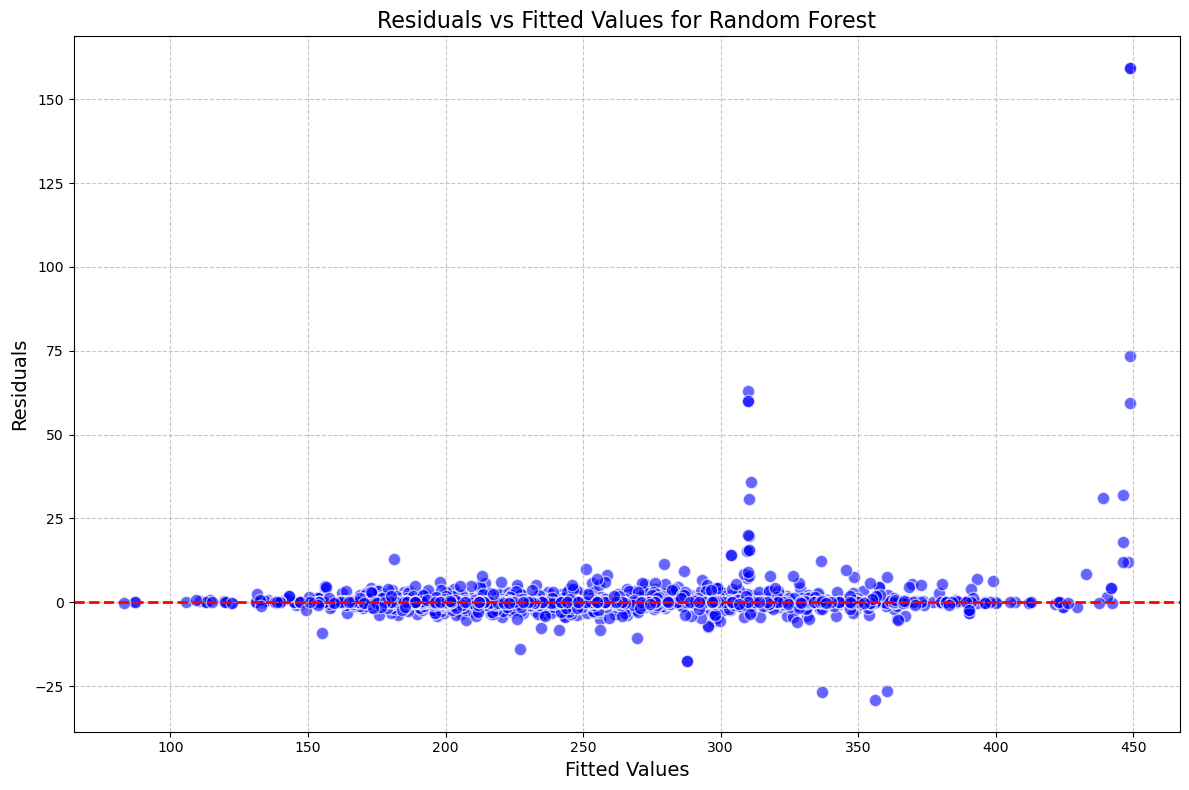

In [128]:
def plot_residuals_vs_fitted(model, X, y):
    # Predict the target values
    y_pred = model.predict(X)

    # Calculate residuals
    residuals = y - y_pred
    fitted_values = y_pred

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Scatter plot for residuals vs. fitted values
    plt.scatter(fitted_values, residuals, alpha=0.6, edgecolor='w', s=80, marker='o', color='blue')

    # Add a horizontal line at 0
    plt.axhline(0, color='red', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Fitted Values', fontsize=14)
    plt.ylabel('Residuals', fontsize=14)
    plt.title(f'Residuals vs Fitted Values for {best_model_name}', fontsize=16)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot with tight layout
    plt.tight_layout()
    plt.show()

print(f"Plotting residuals vs. fitted values and learning curve for {best_model_name}")

# Train best model on entire training data
best_model.fit(X_train_transformed, y_train)

# Plot residuals vs. fitted values
plot_residuals_vs_fitted(best_model, X_val_transformed, y_val)


LEARNING CURVE

Plotting learning curve for Random Forest


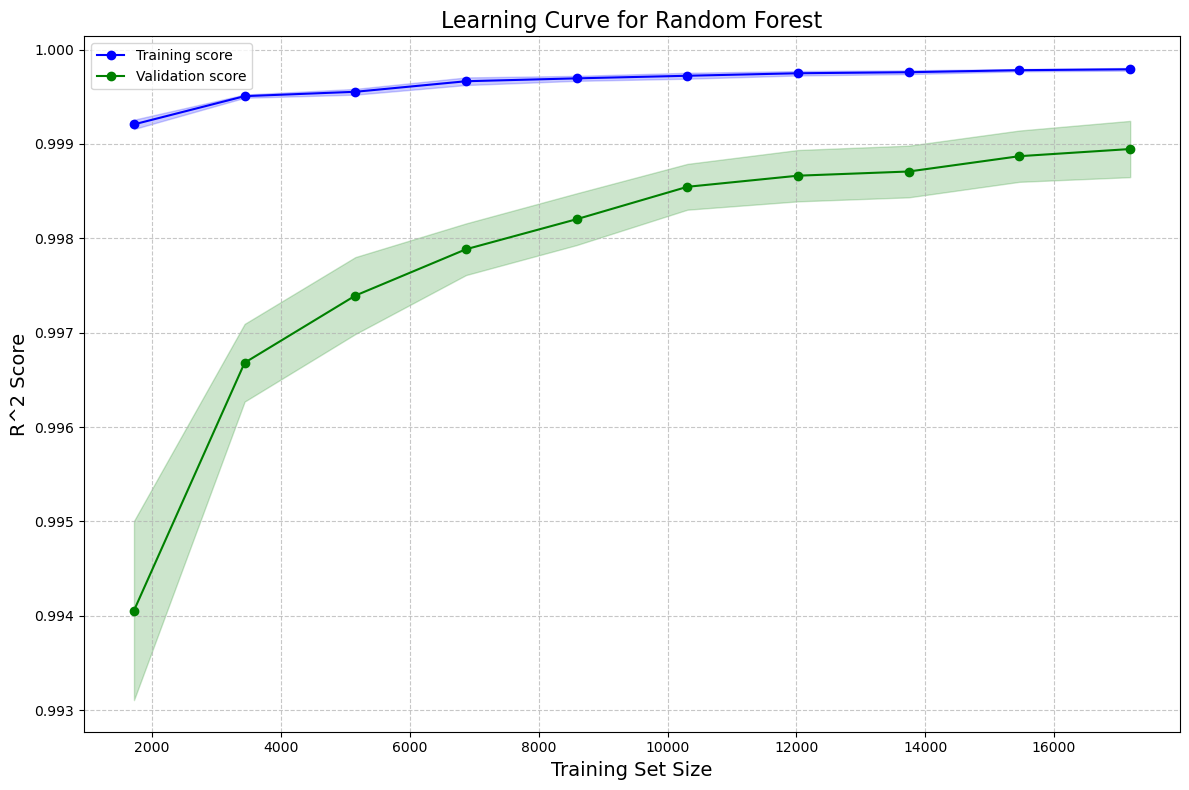

In [129]:
def plot_learning_curve(model, X, y):
    # Compute learning curve data
    train_sizes, train_scores, val_scores = learning_curve(model,X,y,cv=5,scoring='r2',train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_std = val_scores.std(axis=1)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot training scores with error bands
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     color='blue', alpha=0.2)

    # Plot validation scores with error bands
    plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation score')
    plt.fill_between(train_sizes,
                     val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std,
                     color='green', alpha=0.2)

    # Add labels and title
    plt.xlabel('Training Set Size', fontsize=14)
    plt.ylabel('R^2 Score', fontsize=14)
    plt.title(f'Learning Curve for {best_model_name}', fontsize=16)

    # Add grid, legend, and tight layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot learning curve for the best model
print(f"Plotting learning curve for {best_model_name}")
plot_learning_curve(best_model, X_train_transformed, y_train)
